# **Financial Transaction Anomaly Detection**
Team 8: Ching Hsuan (Shawn) Lin, Huawan (Zoey) Zhong, Aryan Sehgal, Jean Miranda Huarancca, Rodrigo Yeo Cordero


# Introduction & motivation

Money laundering threatens the integrity and stability of financial systems worldwide by disguising illicit proceeds as legitimate funds. In this analysis, we bring together transaction data from IBM, advanced anomaly detection techniques, and end-to-end implementation guidance to show you exactly how machine learning models can uncover hidden patterns of illicit behavior in real time. By reading this report, you will gain a clear understanding of the challenges faced by traditional review processes, learn which machine-learning models and features deliver the greatest detection accuracy, and see step-by-step code examples that make it straightforward to deploy and continuously improve your own AML pipeline.  

Our motivation is threefold. First, as transaction volumes soar and laundering methods grow ever more sophisticated, manual review processes struggle to be efficiency and cost effectiveness. Second, intensifying global AML regulations impose heavy compliance burdens on financial institutions, which must balance risk management against operational costs to avoid penalties and reputational damage. Finally, we would like to apply waht we learn about machine-learning  approaches to offer a scalable, self-learning defense: by automatically surfacing subtle or emerging laundering schemes, these technologies can transform AML from a reactive compliance exercise into a proactive safeguard.

# Project Proposal

This project aims to utilize the IBM Anti-Money Laundering transaction dataset to analyze and identify anomalous behaviors within financial transactions, thereby aiding in the early detection of potential money laundering activities.
We will:  

1. Examine transaction patterns among different banks and accounts, assessing whether high-value or frequent transfers are concentrated in specific sources or destinations.  

2. Compare transaction amounts, payment methods, and currency types used in laundering to identify whether specific payment formats (e.g., ACH, Credit Card, Cheques) or currencies (e.g., USD, Euro, Yuan) are more commonly associated with illicit transactions.  

3. Analyze transaction amounts, frequency, and time-series variations to identify abnormal fluctuations or unusual transaction behaviors.  

4. Apply supervised/unsupervised machine learning models to detect anomalous patterns in the data. To extract insight from the transactions.  

5. Evaluate the effectiveness and accuracy of various machine learning models, such as logistic regression, random forest,K-means, and Isolation Forest in detecting anomalies in real-world anti-money laundering scenarios.

# Dataset Description

1. IBM AML Dataset
(Link: https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml)
- LI-Medium_Trans.csv (lower illicit ratio)
- HI-Medium_Trans.csv (higher illicit ratio)

| Column            | Description                                                                 |
|-------------------|------------------------------------------------------------------------------|
| Timestamp         | Year/Month/Day and Hour:Minute of transaction time                          |
| From Bank         | Numeric code for bank where transaction originates                          |
| Account2          | Hexadecimal code for account where transaction originates                   |
| To Bank           | Numeric code for bank where transaction ends                                |
| Account4          | Hexadecimal code for account where transaction ends                         |
| Amount Received   | Monetary amount received in From account (in currency units of next column) |
| Receiving Currency| Currency used in From account (e.g., USD, EUR)                              |
| Amount Paid       | Monetary amount paid (in currency units of next column)                     |
| Payment Currency  | Currency used for payment (e.g., USD, EUR)                                  |
| Payment Format    | How transaction was conducted: cheque, ACH, wire, credit card, etc.         |
| Is Laundering     | 1 = laundering, 0 = not laundering                                           |

2. Currency.csv -- Self Created

| Column             | Description                                                              |
|--------------------|---------------------------------------------------------------------------|
| Payment Currency   | Name of the currency used for paying (e.g., US Dollar, Euro, Yen)        |
| Receiving Currency | Name of the currency used for receiving the transaction                  |
| ISO_pay            | ISO 4217 code for the payment currency (e.g., USD, EUR, JPY)             |
| Country_pay        | Country or region associated with the payment currency                   |
| Region_pay         | Geographic region of the payment country (e.g., Asia, Europe)            |
| ISO_recv           | ISO 4217 code for the receiving currency                                 |
| Country_recv       | Country or region associated with the receiving currency                 |
| Region_recv        | Geographic region of the receiving country (e.g., Asia, Europe)          |

# Executive Summary

In this project, our goal is to detect potential money laundering activities through transaction analysis. We begin by loading the dataset from our S3 bucket and performing an initial overview of its dimensions and missing values. In our case, we intentionally retain outliers, since they may represent the most suspicious transactions for our analysis. We then merge this main dataset with our currency exchange file.

Next, we carry out exploratory data analysis to uncover key patterns: the time-series behavior of transactions, transaction volumes by region, the currencies in use, and the payment formats most commonly employed. After identifying these insights, we move on to data preprocessing to prepare the data for our machine-learning models. This phase includes converting string fields to numeric values, encoding categorical variables, and standardizing datetime formats.

Once the data are ready, we train a baseline logistic regression model and follow by random forest classifier, using our labeled data for evaluation. We employ LIME to interpret and explain the models’ predictions. Finally, due to computational constraints, we sample the dataset and apply K-means clustering to identify distinct transaction groups, as well as Isolation Forest to compute an anomaly score for each transaction.

# Setup Spark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType
from pyspark.sql.window import Window
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
spark = (
    SparkSession.builder
        .appName("Anomaly Detection") \
        .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/25 20:31:54 INFO SparkEnv: Registering MapOutputTracker
25/04/25 20:31:54 INFO SparkEnv: Registering BlockManagerMaster
25/04/25 20:31:54 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
25/04/25 20:31:55 INFO SparkEnv: Registering OutputCommitCoordinator


In [ ]:
spark

# Load dataset

In [ ]:
BUCKET = "ba843lin-classlabs"
FPATH = f"gs://{BUCKET}/money/HI-Medium_Trans.csv"
FPATH2 = f"gs://{BUCKET}/money/LI-Medium_Trans.csv"
FPATH3 = f"gs://{BUCKET}/money/currency.csv"

himedium = spark.read.option("header", True).csv(FPATH)
limedium = spark.read.option("header", True).csv(FPATH2)
currency = spark.read.option("header", True).csv(FPATH3)

In [ ]:
himedium.printSchema()

root
 |-- Timestamp: string (nullable = true)
 |-- From Bank: string (nullable = true)
 |-- Account2: string (nullable = true)
 |-- To Bank: string (nullable = true)
 |-- Account4: string (nullable = true)
 |-- Amount Received: string (nullable = true)
 |-- Receiving Currency: string (nullable = true)
 |-- Amount Paid: string (nullable = true)
 |-- Payment Currency: string (nullable = true)
 |-- Payment Format: string (nullable = true)
 |-- Is Laundering: string (nullable = true)



In [ ]:
himedium.show(5)

+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|       Timestamp|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|2022/09/01 00:17|      020|800104D70|    020|800104D70|        6794.63|         US Dollar|    6794.63|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:02|    03196|800107150|  03196|800107150|        7739.29|         US Dollar|    7739.29|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:17|    01208|80010E430|  01208|80010E430|        1880.23|         US Dollar|    1880.23|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:03|    01208|80010E650|    020|80010E6F0|    73966883.00|         US Dollar|73966883.

In [ ]:
limedium.printSchema()

root
 |-- Timestamp: string (nullable = true)
 |-- From Bank: string (nullable = true)
 |-- Account2: string (nullable = true)
 |-- To Bank: string (nullable = true)
 |-- Account4: string (nullable = true)
 |-- Amount Received: string (nullable = true)
 |-- Receiving Currency: string (nullable = true)
 |-- Amount Paid: string (nullable = true)
 |-- Payment Currency: string (nullable = true)
 |-- Payment Format: string (nullable = true)
 |-- Is Laundering: string (nullable = true)



In [ ]:
limedium.show(5)

+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|       Timestamp|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|2022/09/01 00:15|      020|800104D70|    020|800104D70|        8095.07|         US Dollar|    8095.07|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:18|    03196|800107150|  03196|800107150|        7739.29|         US Dollar|    7739.29|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:23|    01208|80010E430|  01208|80010E430|        2654.22|         US Dollar|    2654.22|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:19|    03203|80010EA80|  03203|80010EA80|       13284.41|         US Dollar|   13284.

In [ ]:
currency.printSchema()

root
 |-- Payment Currency: string (nullable = true)
 |-- Receiving Currency: string (nullable = true)
 |-- ISO_pay: string (nullable = true)
 |-- Country_pay: string (nullable = true)
 |-- Region_pay: string (nullable = true)
 |-- ISO_recv: string (nullable = true)
 |-- Country_recv: string (nullable = true)
 |-- Region_recv: string (nullable = true)



In [ ]:
currency.show(5)

+----------------+------------------+-------+--------------+-------------+--------+--------------+-------------+
|Payment Currency|Receiving Currency|ISO_pay|   Country_pay|   Region_pay|ISO_recv|  Country_recv|  Region_recv|
+----------------+------------------+-------+--------------+-------------+--------+--------------+-------------+
|             Yen|               Yen|    JPY|         Japan|         Asia|     JPY|         Japan|         Asia|
| Canadian Dollar|   Canadian Dollar|    CAD|        Canada|North America|     CAD|        Canada|North America|
|            Euro|              Euro|    EUR| Multiple (EU)|       Europe|     EUR| Multiple (EU)|       Europe|
|           Rupee|             Rupee|    INR|         India|         Asia|     INR|         India|         Asia|
|        UK Pound|          UK Pound|    GBP|United Kingdom|       Europe|     GBP|United Kingdom|       Europe|
+----------------+------------------+-------+--------------+-------------+--------+-------------

In [ ]:
limedium.count(),himedium.count(),currency.count()

(31251483, 31898238, 15)

# Check Missing Value and Merge HI-medium and LI-medium

In [ ]:
from pyspark.sql.functions import col, sum, when

def check_missing_values(df, df_name="DataFrame"):
    print(f"Missing values in {df_name}:")
    missing = df.select([
        sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
        for c in df.columns
    ])
    missing.show(truncate=False)

In [ ]:
check_missing_values(himedium, "himedium")
check_missing_values(limedium, "limedium")

Missing values in himedium:


+---------+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+
|Timestamp|From Bank|Account2|To Bank|Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+---------+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+
|0        |0        |0       |0      |0       |0              |0                 |0          |0               |0             |0            |
+---------+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+

Missing values in limedium:


+---------+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+
|Timestamp|From Bank|Account2|To Bank|Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+---------+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+
|0        |0        |0       |0      |0       |0              |0                 |0          |0               |0             |0            |
+---------+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+



# Join and Merged Dataset to Currency Data

In [ ]:
merged = himedium.union(limedium)
merged.count()

63149721

In [ ]:
merged = merged.join(
    currency.select("Payment Currency", "ISO_pay", "Country_pay", "Region_pay"),
    on="Payment Currency",
    how="left"
)

In [ ]:
merged = merged.join(
    currency.select("Receiving Currency", "ISO_recv", "Country_recv", "Region_recv"),
    on="Receiving Currency",
    how="left"
)

In [ ]:
merged.limit(5).toPandas()

,Receiving Currency,Payment Currency,Timestamp,From Bank,Account2,To Bank,Account4,Amount Received,Amount Paid,Payment Format,Is Laundering,ISO_pay,Country_pay,Region_pay,ISO_recv,Country_recv,Region_recv
0,US Dollar,US Dollar,2022/09/01 00:17,020,800104D70,020,800104D70,6794.63,6794.63,Reinvestment,0,USD,United States,North America,USD,United States,North America
1,US Dollar,US Dollar,2022/09/01 00:02,03196,800107150,03196,800107150,7739.29,7739.29,Reinvestment,0,USD,United States,North America,USD,United States,North America
2,US Dollar,US Dollar,2022/09/01 00:17,01208,80010E430,01208,80010E430,1880.23,1880.23,Reinvestment,0,USD,United States,North America,USD,United States,North America
3,US Dollar,US Dollar,2022/09/01 00:03,01208,80010E650,020,80010E6F0,73966883.00,73966883.00,Cheque,0,USD,United States,North America,USD,United States,North America
4,US Dollar,US Dollar,2022/09/01 00:02,01208,80010E650,020,80010EA30,45868454.00,45868454.00,Cheque,0,USD,United States,North America,USD,United States,North America


In [ ]:
from pyspark.sql.functions import col, when
# check for international payment
merged = merged.withColumn(
    "Is_Cross_Border",
    when(col("Country_pay") != col("Country_recv"), 1).otherwise(0)
)
merged.filter(col("Is_Cross_Border") == 1).show()

+------------------+----------------+----------------+---------+---------+-------+---------+---------------+-----------+--------------+-------------+-------+-------------+-------------+--------+--------------+-------------+---------------+
|Receiving Currency|Payment Currency|       Timestamp|From Bank| Account2|To Bank| Account4|Amount Received|Amount Paid|Payment Format|Is Laundering|ISO_pay|  Country_pay|   Region_pay|ISO_recv|  Country_recv|  Region_recv|Is_Cross_Border|
+------------------+----------------+----------------+---------+---------+-------+---------+---------------+-----------+--------------+-------------+-------+-------------+-------------+--------+--------------+-------------+---------------+
|              Euro|       US Dollar|2022/09/01 00:19|   004011|8032D1A00| 004011|8032D1A00|          97.27|     113.98|           ACH|            0|    USD|United States|North America|     EUR| Multiple (EU)|       Europe|              1|
|          UK Pound|       US Dollar|202

In [ ]:
merged.filter(col("Is_Cross_Border") == 1).limit(5).toPandas()

,Receiving Currency,Payment Currency,Timestamp,From Bank,Account2,To Bank,Account4,Amount Received,Amount Paid,Payment Format,Is Laundering,ISO_pay,Country_pay,Region_pay,ISO_recv,Country_recv,Region_recv,Is_Cross_Border
0,Euro,US Dollar,2022/09/01 00:19,004011,8032D1A00,004011,8032D1A00,97.27,113.98,ACH,0,USD,United States,North America,EUR,Multiple (EU),Europe,1
1,UK Pound,US Dollar,2022/09/01 00:13,005991,80341B8B0,005991,80341B8B0,14.26,18.42,ACH,0,USD,United States,North America,GBP,United Kingdom,Europe,1
2,Euro,US Dollar,2022/09/01 00:18,000,800417500,000,800417500,42.41,49.69,ACH,0,USD,United States,North America,EUR,Multiple (EU),Europe,1
3,US Dollar,Euro,2022/09/01 00:11,03504,800492D00,03504,800492D00,6707.83,5724.46,ACH,0,EUR,Multiple (EU),Europe,USD,United States,North America,1
4,Euro,US Dollar,2022/09/01 00:29,001488,800C948C0,001488,800C948C0,42.71,50.05,ACH,0,USD,United States,North America,EUR,Multiple (EU),Europe,1


In [ ]:
merged.cache()

DataFrame[Receiving Currency: string, Payment Currency: string, Timestamp: string, From Bank: string, Account2: string, To Bank: string, Account4: string, Amount Received: string, Amount Paid: string, Payment Format: string, Is Laundering: string, ISO_pay: string, Country_pay: string, Region_pay: string, ISO_recv: string, Country_recv: string, Region_recv: string, Is_Cross_Border: int]

# EDA

### Transaction Overtime

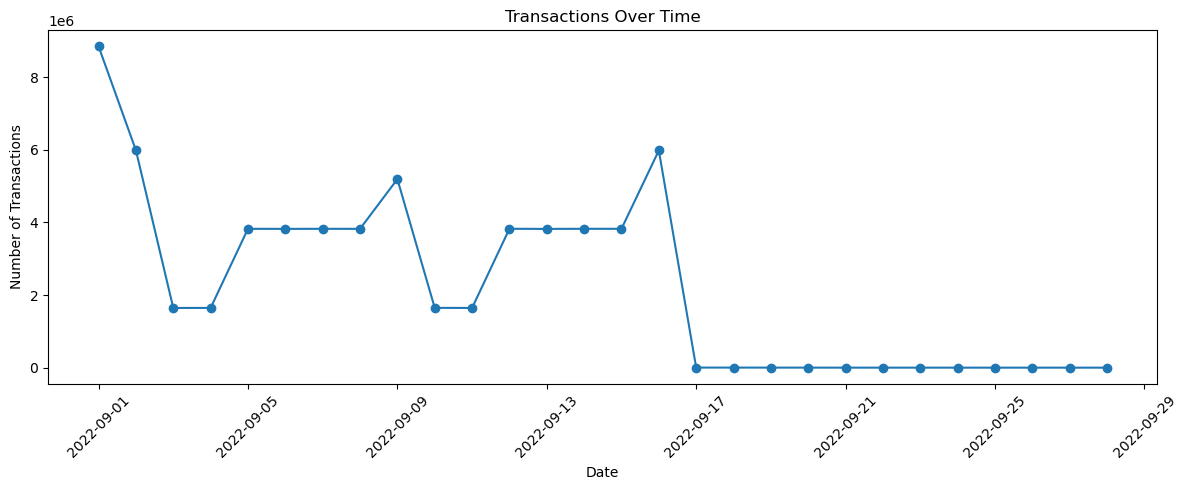

In [ ]:
from pyspark.sql.functions import hour, dayofweek, dayofmonth, to_date
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import concat_ws, col, count as spark_count
from pyspark.sql.functions import to_date, count
import matplotlib.pyplot as plt
merged = merged.withColumn("Timestamp_ts", to_timestamp("Timestamp", "yyyy/MM/dd HH:mm"))

transactions_per_day = (
    merged.withColumn("Date", to_date("Timestamp_ts"))
    .groupBy("Date")
    .agg(count("*").alias("Transaction_Count"))
    .orderBy("Date")
)

transactions_pd = transactions_per_day.toPandas()

plt.figure(figsize=(12, 5))
plt.plot(transactions_pd["Date"], transactions_pd["Transaction_Count"], marker='o')
plt.title("Transactions Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
merged.groupBy(to_date("Timestamp_ts").alias("Date")).count().orderBy("Date").show(100)

+----------+-------+
|      Date|  count|
+----------+-------+
|2022-09-01|8842919|
|2022-09-02|5981952|
|2022-09-03|1643444|
|2022-09-04|1644585|
|2022-09-05|3821974|
|2022-09-06|3820113|
|2022-09-07|3821791|
|2022-09-08|3821114|
|2022-09-09|5189606|
|2022-09-10|1645950|
|2022-09-11|1643782|
|2022-09-12|3822826|
|2022-09-13|3819201|
|2022-09-14|3822222|
|2022-09-15|3821917|
|2022-09-16|5977968|
|2022-09-17|   2400|
|2022-09-18|   1944|
|2022-09-19|   1439|
|2022-09-20|   1066|
|2022-09-21|    659|
|2022-09-22|    374|
|2022-09-23|    150|
|2022-09-24|    115|
|2022-09-25|    114|
|2022-09-26|     60|
|2022-09-27|     29|
|2022-09-28|      7|
+----------+-------+



This time series plot shows daily transaction volume, revealing a sharp drop after mid-September, which may indicate data sparsity, reduced activity, or logging issues in the latter half of the month.

### Transaction patterns in weeks

/tmp/ipykernel_12583/881473035.py:18: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=weekly_pattern_pd, x="DayOfWeek", y="Transactions", palette="Blues_d")


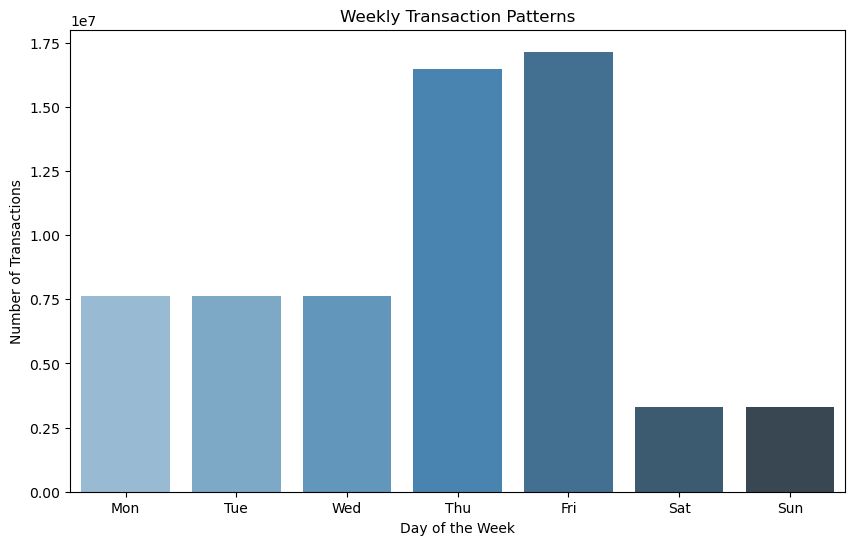

In [ ]:
from pyspark.sql.functions import date_format

# Add day of week
weekly_pattern = merged.withColumn("DayOfWeek", date_format("Timestamp_ts", "E"))

weekly_pattern_df = weekly_pattern.groupBy("DayOfWeek").agg(count("*").alias("Transactions")) \
                                  .orderBy("DayOfWeek")

weekly_pattern_pd = weekly_pattern_df.toPandas()

# Ensure correct weekday order
weekday_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
weekly_pattern_pd["DayOfWeek"] = pd.Categorical(weekly_pattern_pd["DayOfWeek"], categories=weekday_order, ordered=True)
weekly_pattern_pd = weekly_pattern_pd.sort_values("DayOfWeek")

# Plot Weekly Transaction Pattern
plt.figure(figsize=(10,6))
sns.barplot(data=weekly_pattern_pd, x="DayOfWeek", y="Transactions", palette="Blues_d")
plt.title("Weekly Transaction Patterns")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Transactions")
plt.show()

/tmp/ipykernel_12583/1998683870.py:29: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


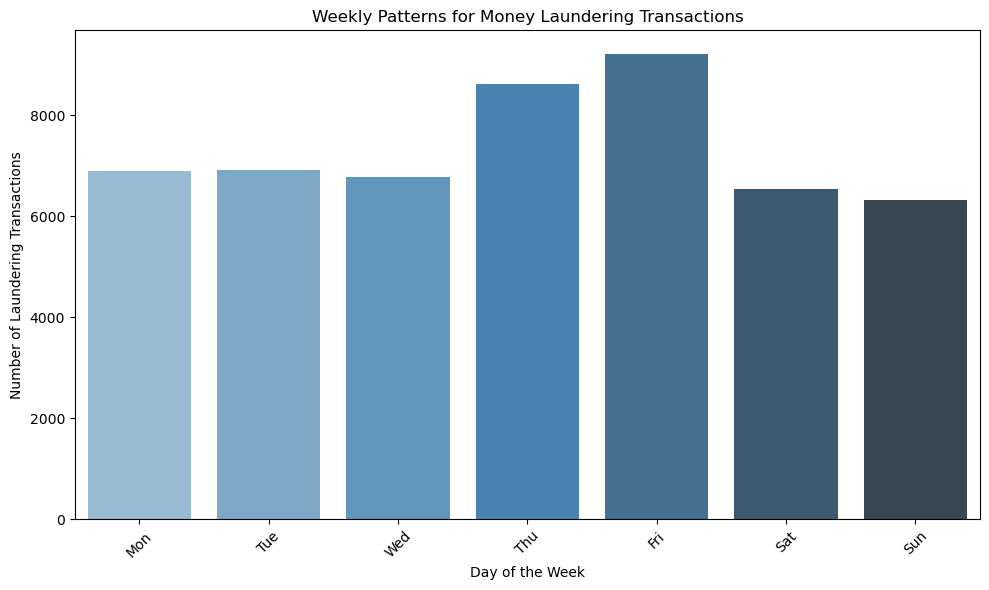

In [ ]:
from pyspark.sql.functions import date_format, count, col
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filter for money laundering transactions only
laundering_weekly = merged.filter(col("Is Laundering") == "1")

# Extract day of week
laundering_weekly_pattern = laundering_weekly.withColumn("Day_Week", date_format("Timestamp_ts", "E"))

laundering_weekly_pattern_df = laundering_weekly_pattern.groupBy("Day_Week") \
                                .agg(count("*").alias("Transactions")) \
                                .orderBy("Day_Week")

laundering_weekly_pattern_pd = laundering_weekly_pattern_df.toPandas()

# Order weekdays correctly
weekday_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
laundering_weekly_pattern_pd["Day_Week"] = pd.Categorical(
    laundering_weekly_pattern_pd["Day_Week"],
    categories=weekday_order,
    ordered=True
)
laundering_weekly_pattern_pd = laundering_weekly_pattern_pd.sort_values("Day_Week")

# Plot Weekly Money Laundering Transactions
plt.figure(figsize=(10, 6))
sns.barplot(
    data=laundering_weekly_pattern_pd,
    x="Day_Week",
    y="Transactions",
    palette="Blues_d"
)
plt.title("Weekly Patterns for Money Laundering Transactions")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Laundering Transactions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Transaction distribution in Hour

In [ ]:
from pyspark.sql.functions import hour, dayofweek, dayofmonth, to_date
from pyspark.sql.functions import to_timestamp

merged = merged.withColumn("Timestamp_ts", to_timestamp("Timestamp", "yyyy/MM/dd HH:mm"))

In [ ]:
merged.printSchema()

root
 |-- Receiving Currency: string (nullable = true)
 |-- Payment Currency: string (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- From Bank: string (nullable = true)
 |-- Account2: string (nullable = true)
 |-- To Bank: string (nullable = true)
 |-- Account4: string (nullable = true)
 |-- Amount Received: string (nullable = true)
 |-- Amount Paid: string (nullable = true)
 |-- Payment Format: string (nullable = true)
 |-- Is Laundering: string (nullable = true)
 |-- ISO_pay: string (nullable = true)
 |-- Country_pay: string (nullable = true)
 |-- Region_pay: string (nullable = true)
 |-- ISO_recv: string (nullable = true)
 |-- Country_recv: string (nullable = true)
 |-- Region_recv: string (nullable = true)
 |-- Is_Cross_Border: integer (nullable = false)
 |-- Timestamp_ts: timestamp (nullable = true)



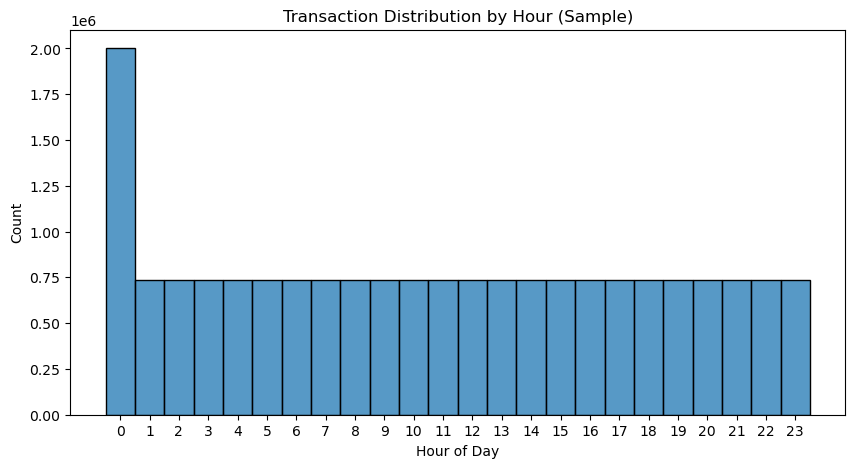

In [ ]:
df_sample = merged.sample(False, 0.3, seed=42)

from pyspark.sql.functions import hour

df_sample = df_sample.withColumn("Hour", hour("Timestamp_ts"))

hour_pd = df_sample.select("Hour").toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(hour_pd["Hour"], bins=24, discrete=True)
plt.title("Transaction Distribution by Hour (Sample)")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.xticks(range(0, 24))
plt.show()

The transaction volume at midnight (Hour = 0) is significantly higher than any other hour of the day, suggesting a potential anomaly. This unusual spike during non-business hours may indicate automated or scripted behavior, which is often associated with attempts to evade detection in money laundering schemes. Further investigation into these transactions—such as their origin, destination, currency, and format—could reveal suspicious patterns not typically observed during regular hours.

### Boarder-cross vs domestic pie chart

In [ ]:
cross_border_count = merged.groupBy("Is_Cross_Border").count()
cross_border_pd = cross_border_count.toPandas()

In [ ]:
cross_border_pd["trans_label"] = cross_border_pd["Is_Cross_Border"].map({0: "Domestic", 1: "International"})

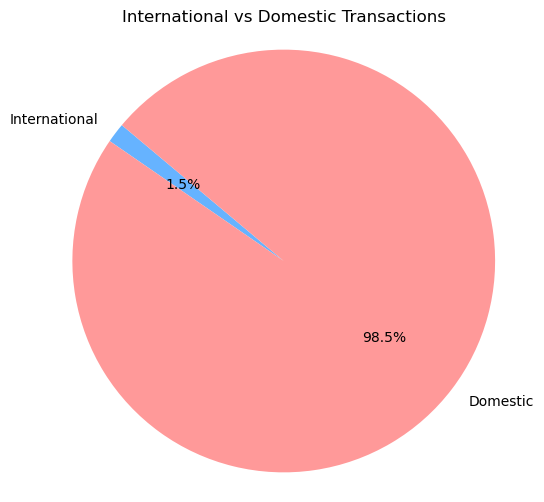

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.pie(cross_border_pd["count"],
        labels=cross_border_pd["trans_label"],
        autopct='%1.1f%%',
        startangle=140,
        colors=["#66b3ff", "#ff9999"])
plt.title("International vs Domestic Transactions")
plt.axis("equal")  #
plt.show()

The vast majority of transactions (98.5%) are domestic, while only 1.5% are international. Although international transactions represent a small portion of the total volume, they may carry higher risk in AML contexts due to the potential for cross-border money movement and regulatory loopholes. This small segment warrants closer inspection, as illicit activities are often hidden in less frequent but higher-risk transaction types.

### Country-Level Distribution of Financial Transactions: Paid vs. Received

In [ ]:
from pyspark.sql.functions import count, col, round, sum as spark_sum

# Group by country for payment and receiving
country_paid = merged.groupBy("Country_pay").agg(count("Country_pay").alias("Number_of_Country_paid"))
country_received = merged.groupBy("Country_recv").agg(count("Country_recv").alias("Number_of_Country_recv"))

# calculate the sum
total_paid = country_paid.agg(spark_sum("Number_of_Country_paid")).first()[0]
total_received = country_received.agg(spark_sum("Number_of_Country_recv")).first()[0]

# add a percentage column
country_paid = country_paid.withColumn(
    "Percentage_of_Country_Paid",
    round((col("Number_of_Country_paid") / total_paid) * 100, 2)
)

country_received = country_received.withColumn(
    "Percentage_of_Country_Received",
    round((col("Number_of_Country_recv") / total_received) * 100, 2)
)

paid_table = country_paid.orderBy("Percentage_of_Country_Paid", ascending=False).toPandas()
received_table = country_received.orderBy("Percentage_of_Country_Received", ascending=False).toPandas()

In [ ]:
paid_table

,Country_pay,Number_of_Country_paid,Percentage_of_Country_Paid
0,United States,23527542,37.26
1,Multiple (EU),14685551,23.26
2,China,4026928,6.38
3,Canada,2082605,3.30
4,Israel,2041254,3.23
5,India,1967227,3.12
6,United Kingdom,1967903,3.12
7,Australia,1880635,2.98
8,Switzerland,1827814,2.89
9,Russia,1789410,2.83


In [ ]:
received_table

,Country_recv,Number_of_Country_recv,Percentage_of_Country_Received
0,United States,23348844,36.97
1,Multiple (EU),14709480,23.29
2,China,3948096,6.25
3,Canada,2104931,3.33
4,Israel,2070793,3.28
5,India,1981518,3.14
6,United Kingdom,1969227,3.12
7,Australia,1907030,3.02
8,Switzerland,1854902,2.94
9,Russia,1813587,2.87


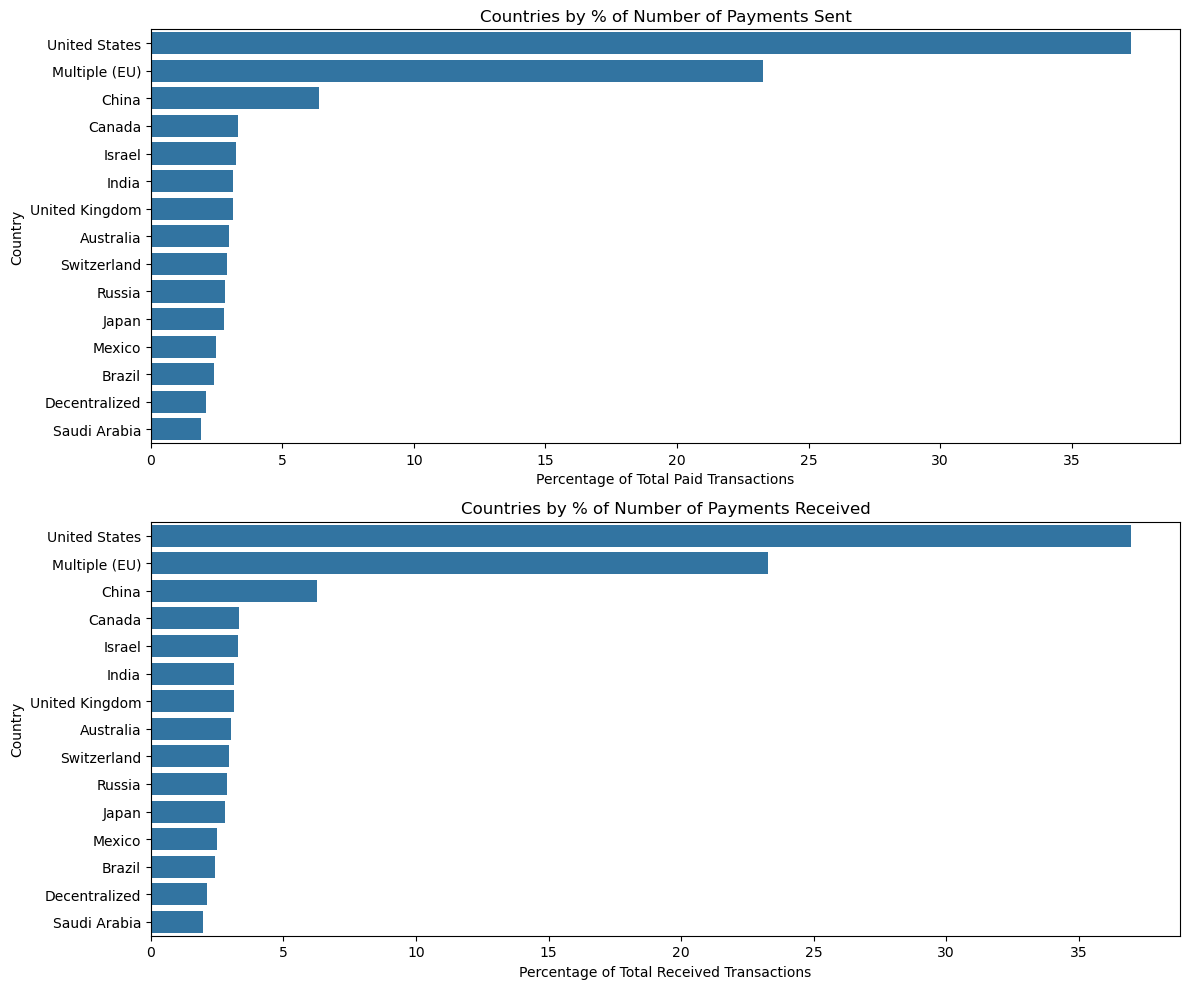

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, axes = plt.subplots(2, 1, figsize=(12, 10))  #2x1

sns.barplot(
    data=paid_table,
    y="Country_pay",
    x="Percentage_of_Country_Paid",
    ax=axes[0]
)
axes[0].set_title("Countries by % of Number of Payments Sent")
axes[0].set_xlabel("Percentage of Total Paid Transactions")
axes[0].set_ylabel("Country")


sns.barplot(
    data=received_table,
    y="Country_recv",
    x="Percentage_of_Country_Received",
    ax=axes[1]
)
axes[1].set_title("Countries by % of Number of Payments Received")
axes[1].set_xlabel("Percentage of Total Received Transactions")
axes[1].set_ylabel("Country")

plt.tight_layout()
plt.show()

These two charts show that the United States is the dominant player in both sending and receiving transactions, followed closely by the European Union and China, with a long tail of other countries contributing smaller but consistent volumes. The relative proportions across the countries are very similar to the sending chart, suggesting that many countries are both frequent senders and recipients. However, small differences could be worth investigating for net transaction flow imbalances.


### Currency Pairs Ranking by Transaction Count

In [ ]:
# Convert to float just in case
from pyspark.sql.functions import col

merged = merged.withColumn("Amount Received", col("Amount Received").cast("float"))
merged = merged.withColumn("Amount Paid", col("Amount Paid").cast("float"))

# Describe in Spark
desc_df = merged.describe(["Amount Received", "Amount Paid"])

# Convert to Pandas and round
desc_pd = desc_df.toPandas()
desc_pd[['Amount Received', 'Amount Paid']] = desc_pd[['Amount Received', 'Amount Paid']].astype(float).round(2)

# Display clean table
print(desc_pd)

  summary  Amount Received   Amount Paid
0   count     6.314972e+07  6.314972e+07
1    mean     7.184469e+06  4.899904e+06
2  stddev     2.221946e+09  1.600085e+09
3     min     0.000000e+00  0.000000e+00
4     max     8.158609e+12  8.158609e+12


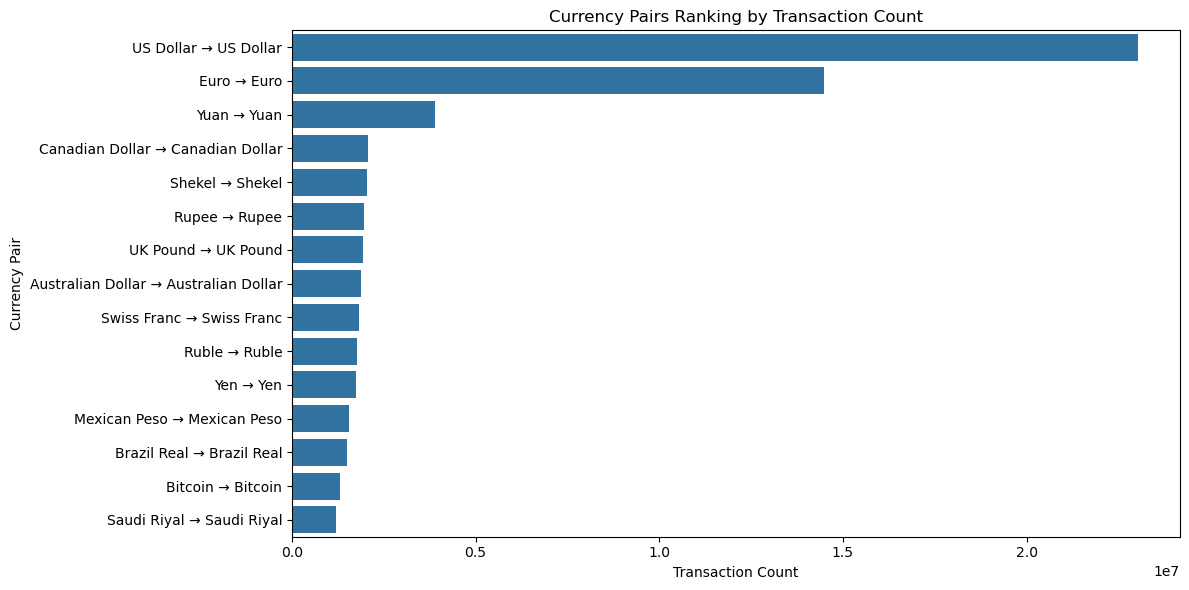

In [ ]:
from pyspark.sql.functions import concat_ws, col, count as spark_count
import matplotlib.pyplot as plt
import seaborn as sns

currency_pair_df = merged.withColumn(
    "Currency_Pair",
    concat_ws(" → ", col("Payment Currency"), col("Receiving Currency"))
)

currency_pair_counts = currency_pair_df.groupBy("Currency_Pair").agg(
    spark_count("*").alias("count")
).orderBy(col("count").desc()).limit(15)

currency_pair_pd = currency_pair_counts.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=currency_pair_pd, x="count", y="Currency_Pair")
plt.title("Currency Pairs Ranking by Transaction Count")
plt.xlabel("Transaction Count")
plt.ylabel("Currency Pair")
plt.tight_layout()
plt.show()

The chart shows that the majority of transactions occur within the same currency, with USD→USD and Euro→Euro dominating the top currency pairs, highlighting a strong preference for domestic currency exchanges.

### Types of payment formats associated with all transactions

In [ ]:
totpayment_format = merged.groupBy("Payment Format").count()
totpayment_format_pd = totpayment_format.toPandas().sort_values(by="count", ascending=False)
totpayment_format_pd["count_millions"] = totpayment_format_pd["count"] / 1_000_000

/tmp/ipykernel_12583/1658499663.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=totpayment_format_pd, x="Payment Format", y="count_millions", palette="Set2")


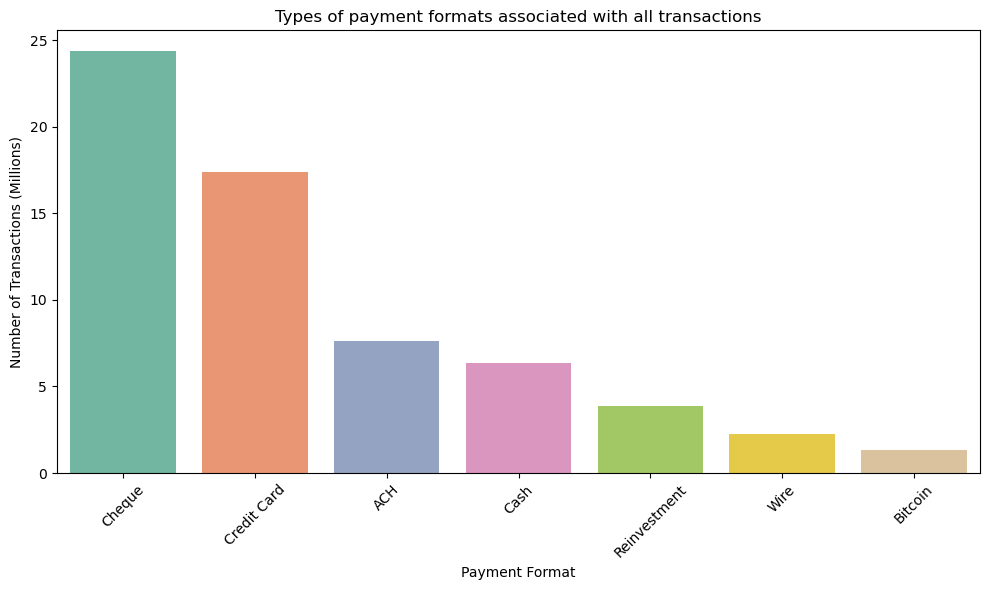

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=totpayment_format_pd, x="Payment Format", y="count_millions", palette="Set2")
plt.title("Types of payment formats associated with all transactions")
plt.xlabel("Payment Format")
plt.ylabel("Number of Transactions (Millions)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The results indicate that Cheques and Credit Cards lead in payment transaction volume, with approximately 24 million and 17.5 million transactions, respectively. In contrast, Wire, Reinvestment, and particularly Bitcoin show minimal usage, highlighting their limited adoption in payment transactions.

### Payment format used in money laundering transactions

In [ ]:
laundering_only = merged.filter(col("Is Laundering") == "1")

In [ ]:
Paymentformat = laundering_only.groupBy("Payment Format").count()
Paymentformat_pd = Paymentformat.toPandas().sort_values(by="count", ascending=False)

/tmp/ipykernel_12583/1765365685.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=Paymentformat_pd, x="Payment Format", y="count", palette="Set2")


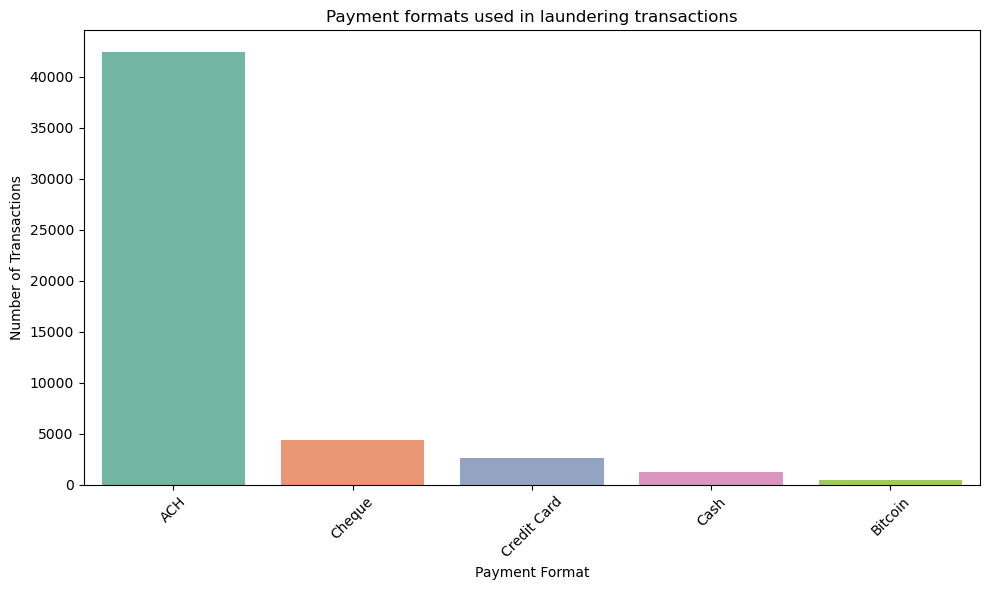

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=Paymentformat_pd, x="Payment Format", y="count", palette="Set2")
plt.title("Payment formats used in laundering transactions")
plt.xlabel("Payment Format")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipykernel_12583/1738740680.py:17: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=laundering_avg_pd,


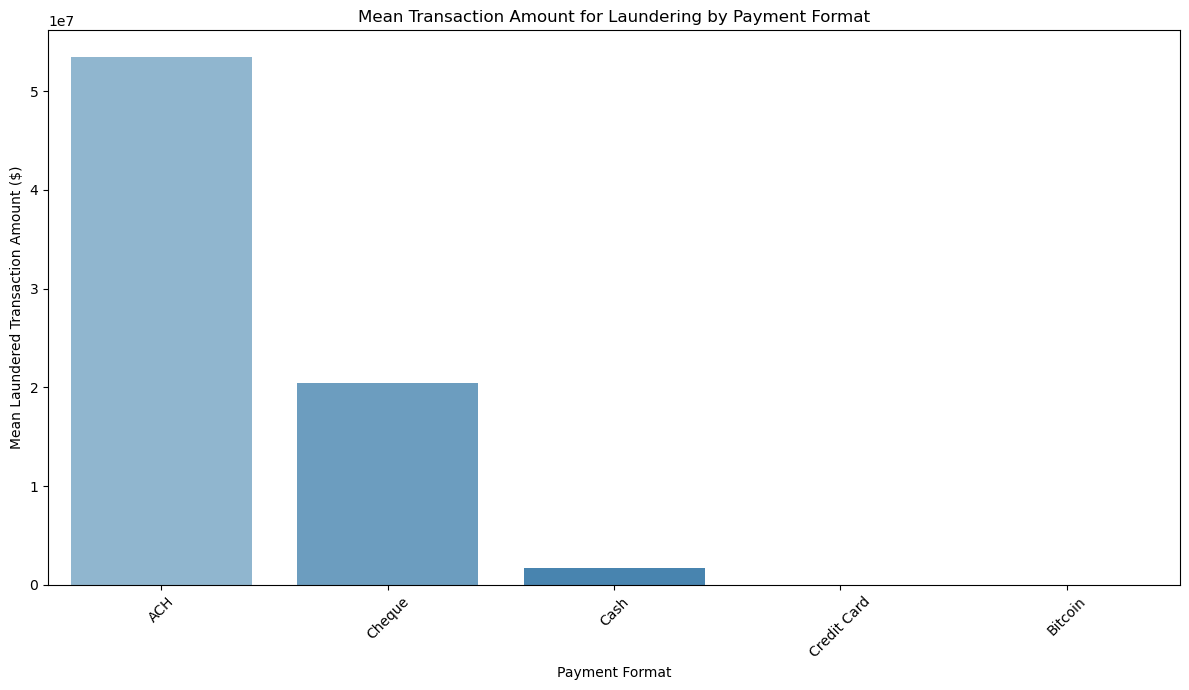

In [ ]:
from pyspark.sql.functions import mean

# Filter only laundering transactions and cast amounts as floats
laundering_amount_df = merged.filter(col("Is Laundering") == "1") \
                             .withColumn("Amount_Paid", col("Amount Paid").cast("float"))

# Average amount laundered per payment format
laundering_avg_df = laundering_amount_df.groupBy("Payment Format") \
                                        .agg(mean("Amount_Paid").alias("Avg_Laundered_Amount")) \
                                        .orderBy(col("Avg_Laundered_Amount").desc())

# Convert to pandas for plotting
laundering_avg_pd = laundering_avg_df.toPandas()

# Plot average amount laundered per payment format
plt.figure(figsize=(12, 7))
sns.barplot(data=laundering_avg_pd,
            x="Payment Format",
            y="Avg_Laundered_Amount",
            palette="Blues_d")

plt.title("Mean Transaction Amount for Laundering by Payment Format")
plt.xlabel("Payment Format")
plt.ylabel("Mean Laundered Transaction Amount ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The results highlight that ACH is the predominant format used in laundering transactions, with over 40,000 instances, surpassing all other methods. In contrast, Cheques, Credit Cards, Cash, and Bitcoin show significantly lower volumes.

# EDA summary

Our exploratory data analysis revealed several noteworthy patterns: daily transaction volumes plunged sharply after mid-September possibly due to true declines in activity, data sparsity, or logging issues,while transactions consistently peaked on Thursdays and Fridays, with laundering-flagged transfers following a similar but more even spread across the week, hinting at attempts to mask illicit flows within routine traffic. An unexpected surge at midnight (Hour = 0) suggests scripted or automated behavior often linked to laundering schemes. Although 98.5% of transactions are domestic, the 1.5% that cross borders carry outsized AML risk and deserve closer scrutiny. Geographically, the U.S. dominates both sending and receiving volumes, followed by the EU and China, yet subtle imbalances in net flows could point to hidden money-movement patterns. Currency trades are almost entirely single currency,chiefly USD→USD and EUR→EUR, and payment methods skew heavily toward cheques and credit cards, with wire transfers, reinvestments, and Bitcoin used far less often. Finally, among laundering-flagged transactions, ACH far outpaces all other channels, underscoring its prominence in AML investigations.

# Data preprocessing

In [ ]:
from pyspark.sql.functions import hour, dayofweek, to_timestamp
# Convert timestamp's Data Type to Datatime
merged = merged.withColumn("Timestamp",to_timestamp("Timestamp", "yyyy/MM/dd HH:mm"))

merged = merged.withColumn("hour",  hour("Timestamp"))
merged = merged.withColumn("weekday", dayofweek("Timestamp"))
merged.printSchema()

root
 |-- Receiving Currency: string (nullable = true)
 |-- Payment Currency: string (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- From Bank: string (nullable = true)
 |-- Account2: string (nullable = true)
 |-- To Bank: string (nullable = true)
 |-- Account4: string (nullable = true)
 |-- Amount Received: string (nullable = true)
 |-- Amount Paid: string (nullable = true)
 |-- Payment Format: string (nullable = true)
 |-- Is Laundering: string (nullable = true)
 |-- ISO_pay: string (nullable = true)
 |-- Country_pay: string (nullable = true)
 |-- Region_pay: string (nullable = true)
 |-- ISO_recv: string (nullable = true)
 |-- Country_recv: string (nullable = true)
 |-- Region_recv: string (nullable = true)
 |-- Is_Cross_Border: integer (nullable = false)
 |-- hour: integer (nullable = true)
 |-- weekday: integer (nullable = true)



In [ ]:
from pyspark.sql.functions import col
# Convert the data type from string to numerics
merged = merged.withColumn("Amount_Received", col("Amount Received").cast("double")) \
           .withColumn("Amount_Paid", col("Amount Paid").cast("double"))

merged = merged.withColumn("Is_Laundering", col("Is Laundering").cast("int"))

In [ ]:
# check imbalance
merged.groupBy("Is_Laundering").count().show()

+-------------+--------+
|Is_Laundering|   count|
+-------------+--------+
|            1|   51271|
|            0|63098450|
+-------------+--------+



# Logistic Regression

## Dealing with Class Weight

In [ ]:
from pyspark.sql.functions import when, lit
# calcualte weight
pos_count = merged.filter(col("Is_Laundering") == 1).count()
neg_count = merged.filter(col("Is_Laundering") == 0).count()
weight_for_1 = neg_count / pos_count

merged = merged.withColumn(
    "classWeightCol",
    when(col("Is_Laundering") == 1, lit(weight_for_1)).otherwise(lit(1.0))
)

## Train LR Model

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import FeatureHasher
from pyspark.ml.classification import LogisticRegression

categorical_cols = [
    "Receiving Currency", "Payment Currency", "Payment Format",
    "ISO_pay", "Country_pay", "Region_pay", "ISO_recv", "Country_recv", "Region_recv"
]

numeric_cols = ["Amount_Received", "Amount_Paid", "Is_Cross_Border", "hour", "weekday"]

# put categorical+numeric to hasher
hasher = FeatureHasher(
    inputCols=categorical_cols + numeric_cols,
    outputCol="features",
    numFeatures=512
)

# model
lr = LogisticRegression(
    featuresCol="features",
    labelCol="Is_Laundering",
    weightCol="classWeightCol",
    maxIter=20,
    regParam=0.1,
    elasticNetParam=0.0
)

pipeline = Pipeline(stages=[hasher, lr])

# 3. train/test split + fit
train_df, test_df = merged.randomSplit([0.7, 0.3], seed=3407)
model    = pipeline.fit(train_df)
preds    = model.transform(test_df)
preds.select("prediction", "probability", "Is_Laundering").show(5)

25/04/25 21:11:38 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+--------------------+-------------+
|prediction|         probability|Is_Laundering|
+----------+--------------------+-------------+
|       0.0|[0.76456983132338...|            0|
|       1.0|[0.22589100828622...|            0|
|       0.0|[0.85598779748143...|            0|
|       0.0|[0.85920865955233...|            0|
|       0.0|[0.74084831910604...|            0|
+----------+--------------------+-------------+
only showing top 5 rows



## Confusion matrix

In [ ]:
# confusion matrix
import pandas as pd
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col

# 1. convert predictions to RDD[(prediction, label)]
rdd_pred_label = preds.select(
    col("prediction").cast("double"),
    col("Is_Laundering").cast("double")
).rdd.map(lambda r: (r[0], r[1]))

# create metric
metrics = MulticlassMetrics(rdd_pred_label)
cm = metrics.confusionMatrix().toArray()

# convert to DataFrame with label
df_cm = pd.DataFrame(
    cm,
    index=["Actual 0 (Neg)", "Actual 1 (Pos)"],
    columns=["Pred 0 (Neg)",  "Pred 1 (Pos)"]
)

print("Confusion Matrix:")
print(df_cm.to_string())

/usr/lib/spark/python/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
25/04/25 05:08:07 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_159_27 !
25/04/25 05:08:07 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_159_43 !
25/04/25 05:08:07 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_159_39 !
25/04/25 05:08:07 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_159_11 !
25/04/25 05:08:07 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_159_15 !
25/04/25 05:08:07 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_159_7 !
25/04/25 05:08:07 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_159_35 !
25/04/25 05:08:07 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_159_31 !
25/04/25 05:08:07 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_159_

Confusion Matrix:
                Pred 0 (Neg)  Pred 1 (Pos)
Actual 0 (Neg)    16935016.0     1995639.0
Actual 1 (Pos)        2651.0       12644.0


## Model Evaluation

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Accuracy
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="Is_Laundering",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = evaluator_acc.evaluate(preds)

# Precision（1）
evaluator_pr = MulticlassClassificationEvaluator(
    labelCol="Is_Laundering",
    predictionCol="prediction",
    metricName="precisionByLabel"
)
precision = evaluator_pr.evaluate(preds, {evaluator_pr.metricLabel: 1.0})

# Recall（1）
evaluator_rec = MulticlassClassificationEvaluator(
    labelCol="Is_Laundering",
    predictionCol="prediction",
    metricName="recallByLabel"
)
recall = evaluator_rec.evaluate(preds, {evaluator_rec.metricLabel: 1.0})

print(f"Accuracy = {accuracy:.4f}")
print(f"Precision(1) = {precision:.4f}")
print(f"Recall(1)    = {recall:.4f}")

Accuracy = 0.8945
Precision(1) = 0.0063
Recall(1)    = 0.8267


Our model does flag a lot of normal transactions nearly two million as suspicious, but that’s a trade‐off we’re okay with in AML work. It’s far worse to miss a real laundering case than to ask an analyst to double‐check an extra few alerts. Regulators expect us to catch almost everything that looks off, and downstream checks—simple rules or a quick risk‐score review—can knock out most of the false alarms. If we ever need fewer alerts, we can tweak the score threshold or class weights to cut down on false positives without letting more real cases slip through.

## Using LIME to Explain Logistic Regression Model

In [ ]:
import numpy as np
from pyspark.sql.functions import col, rand
from lime.lime_tabular import LimeTabularExplainer
# We tried to extract 10 percent of the prediction label = 1.0 to see what features contribute the most to the laundering transaction
sample4lime = (
    preds
      .filter(col("prediction") == 1.0)
      .orderBy(rand())               # extract laundering data randomly
      .limit(1200)                    # extract 1200 rows
      .select(*(categorical_cols + numeric_cols + ["Is_Laundering"]))
)
pdf = sample4lime.toPandas()

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
# Ordinal Encoder
enc = OrdinalEncoder()
pdf_cat = pdf[categorical_cols]
X_cat = enc.fit_transform(pdf_cat)
# Extract the original name of the feature (Becasue we used hashing above)
categorical_names = {
    i: list(enc.categories_[i])
    for i in range(len(categorical_cols))
}

# numerical column
X_num = pdf[numeric_cols].values

# combine for the LIME result
X_enc = np.hstack([X_cat, X_num])
feature_names = categorical_cols + numeric_cols

# build y
y = pdf["Is_Laundering"].astype(int).values

# Initialize Lime instance
explainer = LimeTabularExplainer(
    training_data        = X_enc,
    feature_names        = feature_names,
    class_names          = ["normal","laundering"],
    mode                 = "classification",
    categorical_features = list(range(len(categorical_cols))),
    categorical_names    = categorical_names,
    discretize_continuous=False
)


def predict_proba_fn(X_numpy: np.ndarray):
    X_cat_new = X_numpy[:, :len(categorical_cols)]
    X_num_new = X_numpy[:, len(categorical_cols):]
    df_cat = pd.DataFrame(
        np.round(X_cat_new).astype(int),
        columns=categorical_cols
    )
    for i, col_name in enumerate(categorical_cols):
        df_cat[col_name] = df_cat[col_name]\
            .map(lambda code: categorical_names[i][code])
    df_num = pd.DataFrame(X_num_new, columns=numeric_cols)
    pdf2   = pd.concat([df_cat, df_num], axis=1)
    sdf2   = spark.createDataFrame(pdf2)
    probs  = model.transform(sdf2).select("probability").collect()
    return np.array([row["probability"] for row in probs])

# explain the first sample
exp = explainer.explain_instance(
    data_row     = X_enc[0],
    predict_fn   = predict_proba_fn,
    num_features = 10
)

print("--- LIME explanation for sample #0 ---")
for feat, w in exp.as_list():
    print(f"{feat:30s} → {w:+.4f}")

--- LIME explanation for sample #0 ---
weekday                        → -0.0182
ISO_pay=EUR                    → +0.0128
hour                           → +0.0109
Region_recv=Europe             → +0.0099
Country_recv=Multiple (EU)     → -0.0049
Region_pay=Europe              → -0.0045
Payment Currency=Euro          → +0.0023
ISO_recv=EUR                   → -0.0013
Country_pay=Multiple (EU)      → +0.0011
Receiving Currency=Euro        → +0.0010


## Explain all 1200 samples

In [ ]:
from collections import defaultdict
import numpy as np
import pandas as pd

# collect the LIME weight from each feature on each sample
weights = defaultdict(list)

n_samples = X_enc.shape[0]

for i in range(n_samples):
    exp = explainer.explain_instance(
        data_row     = X_enc[i],
        predict_fn   = predict_proba_fn,
        num_features = len(feature_names)
    )
    for feat, w in exp.as_list():
        weights[feat].append(w)

# took the mean of all the weight we collect
avg_weights = { feat: np.mean(ws) for feat, ws in weights.items() }

# convert it to DataFrame, order by avg_weight
importance_df = (
    pd.DataFrame.from_dict(
      avg_weights, orient="index", columns=["avg_weight"]
    )
    .reset_index()
    .rename(columns={"index":"feature"})
    .sort_values("avg_weight", ascending=False)
)

# Top 20 suspicious features
print(importance_df.head(20))

                            feature  avg_weight
14                      ISO_pay=AUD    0.158493
31        Region_pay=Eastern Europe    0.010736
42        Payment Currency=UK Pound    0.010103
38      Country_recv=United Kingdom    0.008619
34               Country_pay=Russia    0.007742
2                              hour    0.007199
83             Payment Currency=Yen    0.006877
41       Country_pay=United Kingdom    0.006385
79                Country_pay=Japan    0.006253
78           Receiving Currency=Yen    0.005599
68               Country_recv=China    0.005559
36              Country_recv=Russia    0.005455
30         Receiving Currency=Ruble    0.005161
76  Receiving Currency=Mexican Peso    0.005020
81               Country_recv=Japan    0.004996
1        Country_recv=Multiple (EU)    0.004792
40      Receiving Currency=UK Pound    0.004435
71          Receiving Currency=Yuan    0.004435
37                     ISO_recv=RUB    0.004362
43                     ISO_recv=GBP    0

The LIME explanation for sample 1000 shows that ISO_pay=AUD carries by far the greatest positive weight (0.168), making AUD-denominated transfers the strongest risk signal, followed by Country_pay=United Kingdom (0.019) and Receiving Currency=UK Pound (0.017); Transactions received in Japan (0.014) and payments made in Saudi Arabia (0.014) also meaningfully increase risk, while ISO_pay=GBP (0.013), Ruble receipts (0.011), and Eastern Europe flags (≈0.008) have moderate impact and transaction hour (0.007) is negligible. To act on this, automatically route high-value AUD payments to a secondary review queue, enforce enhanced KYC on any UK-linked flows, audit a random sample of Saudi-paying and Japan-receiving transactions to distinguish true risk from data quirks, and streamline alerts into “Tier 1” (e.g. large AUD transfers) versus “Tier 2” (UK and other signals) to help analysts prioritize; meanwhile, drop the time-of-day factor from your rule set and consider augmenting your feature set with dynamic behavior metrics—such as transaction-to-balance ratios or transfer velocity—to capture patterns that static geography indicators miss.

# Random Forest

## Train RF model

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import col


categorical_cols = [
    "Receiving Currency", "Payment Currency", "Payment Format",
    "ISO_pay", "Country_pay", "Region_pay", "ISO_recv", "Country_recv", "Region_recv"
]
numeric_cols = ["Amount_Received", "Amount_Paid", "Is_Cross_Border", "hour", "weekday"]

# StringIndexer + OneHotEncoder for categorical variables
indexers = [StringIndexer(inputCol=col, outputCol=col+"_idx", handleInvalid="keep") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col+"_idx", outputCol=col+"_ohe") for col in categorical_cols]

# Assemble features
assembler_inputs = [col+"_ohe" for col in categorical_cols] + numeric_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

# Initialize model
rf = RandomForestClassifier(featuresCol="features", labelCol="Is_Laundering", numTrees=100, seed=42)

# pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, rf])

# split data
train_df, test_df = merged.randomSplit([0.8, 0.2], seed=843)

major_df = train_df.filter(col("Is_Laundering") == 0)
minor_df = train_df.filter(col("Is_Laundering") == 1)

# the count of laundering
minor_count = minor_df.count()

# Randomly sample the not laundering class to match the laundering class count
sampled_major_df = major_df.sample(withReplacement=False, fraction=minor_count / major_df.count(), seed=42)

# data that is balance
balanced_train_df = sampled_major_df.unionAll(minor_df)

# Fit the pipeline on training data
rf_model = pipeline.fit(balanced_train_df)

# Make predictions on test data
predictions = rf_model.transform(test_df)

predictions.select("Is_Laundering", "probability", "rawPrediction", "prediction").show(5, truncate=False)

25/04/25 21:28:58 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_135_2 !
25/04/25 21:28:58 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_135_5 !
25/04/25 21:28:58 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_135_9 !
25/04/25 21:28:59 WARN YarnAllocator: Container from a bad node: container_1745610079342_0001_01_000008 on host: ba843-team-project-w-1.c.ba843hw-spring2025.internal. Exit status: 143. Diagnostics: [2025-04-25 21:28:58.632]Container killed on request. Exit code is 143
[2025-04-25 21:28:58.632]Container exited with a non-zero exit code 143. 
[2025-04-25 21:28:58.633]Killed by external signal
.
25/04/25 21:28:59 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 8 for reason Container from a bad node: container_1745610079342_0001_01_000008 on host: ba843-team-project-w-1.c.ba843hw-spring2025.internal. Exit status: 143. Diagnostics: [2025-04-25 21:28:58.632]Container killed on 

+-------------+----------------------------------------+--------------------------------------+----------+
|Is_Laundering|probability                             |rawPrediction                         |prediction|
+-------------+----------------------------------------+--------------------------------------+----------+
|0            |[0.7237881489141986,0.2762118510858014] |[72.37881489141988,27.621185108580143]|0.0       |
|0            |[0.6872094798141102,0.31279052018588976]|[68.72094798141103,31.27905201858898] |0.0       |
|0            |[0.6331462767304459,0.36685372326955423]|[63.31462767304458,36.685372326955424]|0.0       |
|0            |[0.7850642561757879,0.21493574382421204]|[78.50642561757877,21.493574382421198]|0.0       |
|0            |[0.7227103256477356,0.2772896743522643] |[72.27103256477356,27.728967435226433]|0.0       |
+-------------+----------------------------------------+--------------------------------------+----------+
only showing top 5 rows



## Calculate AUC

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(
    labelCol="Is_Laundering",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

auc = evaluator.evaluate(predictions)
print(f"AUC: {auc:.4f}")

AUC: 0.8851


## Confusion Matrix and Evaluation

In [ ]:
tp = predictions.filter((col("Is_Laundering") == 1) & (col("prediction") == 1)).count()
tn = predictions.filter((col("Is_Laundering") == 0) & (col("prediction") == 0)).count()
fp = predictions.filter((col("Is_Laundering") == 0) & (col("prediction") == 1)).count()
fn = predictions.filter((col("Is_Laundering") == 1) & (col("prediction") == 0)).count()

print(f"TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")

# Use Pandas show Confusion Matrix
conf_matrix = pd.DataFrame(
    [[tn, fp],
     [fn, tp]],
    columns=["Predicted 0", "Predicted 1"],
    index=["Actual 0", "Actual 1"]
)
print("\nConfusion Matrix:")
print(conf_matrix)


TP: 8172, FP: 1045229, FN: 2022, TN: 11571251

Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0     11571251      1045229
Actual 1         2022         8172


In [ ]:
## Evalutation Metrics
from pyspark.sql.functions import col

def compute_metrics(predictions, label_col="Is_Laundering"):
    tp = predictions.filter((col(label_col) == 1) & (col("prediction") == 1)).count()
    tn = predictions.filter((col(label_col) == 0) & (col("prediction") == 0)).count()
    fp = predictions.filter((col(label_col) == 0) & (col("prediction") == 1)).count()
    fn = predictions.filter((col(label_col) == 1) & (col("prediction") == 0)).count()

    total = tp + tn + fp + fn
    accuracy = (tp + tn) / total if total > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")

compute_metrics(predictions)

Accuracy : 0.9171
Precision: 0.0078
Recall   : 0.8016
F1 Score : 0.0154


In [ ]:
# check the key columns from the predictions
selected_columns = [
    "Receiving Currency",
    "Payment Currency",
    "Amount Received",
    "Amount Paid",
    "Payment Format",
    "hour"
]

pd.set_option("display.max_rows", None)

predictions.filter((col("Is_Laundering") == 1) & (col("prediction") == 1)) \
    .select(*selected_columns) \
    .limit(100) \
    .toPandas()


,Receiving Currency,Payment Currency,Amount Received,Amount Paid,Payment Format,hour
0,Euro,Euro,5117406.94,5117406.94,ACH,12
1,Euro,Euro,13065.12,13065.12,ACH,0
2,Euro,Euro,11440.73,11440.73,ACH,1
3,Euro,Euro,2317.16,2317.16,ACH,7
4,Euro,Euro,8707.67,8707.67,ACH,6
5,Euro,Euro,14567.69,14567.69,ACH,7
6,Euro,Euro,13629.75,13629.75,ACH,11
7,Euro,Euro,11764.25,11764.25,ACH,20
8,Euro,Euro,5591.22,5591.22,ACH,16
9,Ruble,Ruble,1392590.03,1392590.03,ACH,5


In [ ]:
# check the specific hour for laundering
Is_Laundering_df=predictions.filter((col("Is_Laundering") == 1) & (col("prediction") == 1))
Is_Laundering_df.groupBy("hour").count().orderBy("count", ascending = False).show()

+----+-----+
|hour|count|
+----+-----+
|  12|  518|
|  11|  516|
|  13|  501|
|  16|  481|
|  15|  459|
|  14|  451|
|  17|  394|
|   9|  386|
|  10|  371|
|  19|  370|
|  18|  370|
|   8|  363|
|   6|  331|
|   7|  304|
|   5|  295|
|   2|  259|
|   3|  255|
|   0|  252|
|  22|  240|
|   1|  234|
+----+-----+
only showing top 20 rows



In [ ]:
# check the payment format for laundering
Is_Laundering_df.groupBy("Payment Format").count().orderBy("count", ascending = False).show()

+--------------+-----+
|Payment Format|count|
+--------------+-----+
|           ACH| 8172|
+--------------+-----+



Based on our Random Forest results, every flagged transaction was routed through ACH, underscoring the elevated laundering risk associated with this channel. Roughly 60 percent of these suspicious transfers were denominated in Euros, followed by US Dollars, Russian Rubles, and UK Pounds—highlighting the need for heightened scrutiny of Euro-based flows. In terms of timing, laundering activity peaks at 11 AM and 2 PM, yet significant volumes at 1 AM and 5 AM and a consistent presence across all hours suggest that bad actors exploit both high-traffic business windows and off-peak periods to embed illicit transfers within normal transaction flows. Transaction sizes range from a few hundred dollars to over $90 million, demonstrating the model’s ability to detect laundering attempts at both small and large scales.

# Isolation Forest

## Extract Sample Data

In [ ]:
# Take sample
total = merged.count()
N = 1000000
frac = min(N / total, 1.0)
sample_df = merged.sample(False, frac, seed=3407).limit(N)

# convert to Pandas
pdf = sample_df.toPandas()

## Train IF model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest


cat_cols = [
    "Receiving Currency","Payment Currency","Payment Format",
    "ISO_pay","Country_pay","Region_pay",
    "ISO_recv","Country_recv","Region_recv"
]
num_cols = ["Amount_Received","Amount_Paid","Is_Cross_Border","hour","weekday"]


for c in ["Country_pay","Country_recv"]:
    freq = pdf[c].value_counts(normalize=True)
    pdf[f"{c}_freq"] = pdf[c].map(freq)

# OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()
pdf[["RecvCur_enc","PayCur_enc","Fmt_enc","RegPay_enc","RegRecv_enc",
     "ISO_pay_enc","ISO_recv_enc"]] = oe.fit_transform(
    pdf[["Receiving Currency","Payment Currency","Payment Format",
         "Region_pay","Region_recv","ISO_pay","ISO_recv"]]
)

# feature matrix
feature_cols = [
    # rename the column after creating matrix
    "RecvCur_enc","PayCur_enc","Fmt_enc","RegPay_enc","RegRecv_enc","ISO_pay_enc","ISO_recv_enc",
    "Country_pay_freq","Country_recv_freq",
] + num_cols

X = pdf[feature_cols].fillna(0).values

# 5) IsolationForest
iso = IsolationForest(
    n_estimators=100,
    max_samples="auto",
    contamination=0.01,
    random_state=42
)
iso.fit(X)

# score and label
pdf["anomaly_score"] = -iso.decision_function(X)            # larger means more suspicious
pdf["anomaly_flag"]  = (iso.predict(X) == -1).astype(int)   # laundering

## Evaluation

In [ ]:
# sorting the top 20 the score
pd.reset_option('display.float_format')
top20 = pdf.sort_values("anomaly_score", ascending=False).head(20)
formatted = top20.copy()
formatted['Amount_Received'] = formatted['Amount_Received'].map('{:,.0f}'.format)
formatted['Amount_Paid'] = formatted['Amount_Paid'].map('{:,.0f}'.format)

display(formatted[[
    "anomaly_score","anomaly_flag",
    "Receiving Currency","Payment Currency","Region_pay","Region_recv",
    "Amount_Received","Amount_Paid"
]])

,anomaly_score,anomaly_flag,Receiving Currency,Payment Currency,Region_pay,Region_recv,Amount_Received,Amount_Paid
329327,0.123039,1,Yen,US Dollar,North America,Asia,"236,088,216,814","2,239,926,156"
341577,0.118420,1,Yen,US Dollar,North America,Asia,"21,448,052,203","203,491,956"
823782,0.117397,1,Yen,US Dollar,North America,Asia,"4,049,531,255","38,420,600"
270779,0.114576,1,Australian Dollar,US Dollar,North America,Oceania,"187,632,597","132,809,029"
851526,0.114338,1,Yen,US Dollar,North America,Asia,"997,709,078,760","9,465,930,539"
774385,0.114296,1,Yen,US Dollar,North America,Asia,"997,709,078,760","9,465,930,539"
327791,0.113723,1,Yuan,US Dollar,North America,Asia,"208,718,622","31,163,196"
661922,0.113321,1,Yen,US Dollar,North America,Asia,"167,253,926,680","1,586,849,399"
897466,0.111692,1,Yen,US Dollar,North America,Asia,"110,314,377,853","1,046,625,976"
632512,0.111291,1,Rupee,US Dollar,North America,Asia,"33,303,836,156","453,458,910"


Isolation Forest predominantly flags extremely large cross-border transfers as anomalies—most notably North America→Asia yen→USD flows with scores above 0.11 (amounts ranging from tens of millions to over a trillion), followed by AUD→USD, CNY→USD, INR→USD and ILS→USD transactions. These outliers could stem from data entry errors (misplaced decimals or extra zeros) or represent genuinely high-risk laundering activity. To operationalize these insights, manually sample and validate a subset of these high-value, currency-region combinations to rule out technical glitches; codify alerts based on specific currency pairs, origin/destination regions and amount thresholds; and enrich your monitoring with dynamic features—such as transaction frequency, account risk history and velocity metrics—to better discriminate true suspicious behavior from normal large-volume transfers.

# K-means

## Train K-means model

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

merged_sample = merged.sample(fraction=0.1, seed=3407)

categorical_cols = [
    "Receiving Currency", "Payment Currency", "Payment Format",
    "ISO_pay", "Country_pay", "Region_pay", "ISO_recv", "Country_recv", "Region_recv"
]

numeric_cols = ["Amount_Received", "Amount_Paid", "Is_Cross_Border", "hour", "weekday"]


merged_sample = merged.sample(withReplacement=False, fraction=0.1, seed=42)


indexers = [StringIndexer(inputCol=col, outputCol=col+"_idx", handleInvalid="keep") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col+"_idx", outputCol=col+"_ohe") for col in categorical_cols]

assembler_inputs = [col+"_ohe" for col in categorical_cols] + numeric_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

kmeans = KMeans(featuresCol="scaledFeatures", predictionCol="cluster", k=4, seed=42)

pipeline_kmeans = Pipeline(stages=indexers + encoders + [assembler, scaler, kmeans])


kmeans_model = pipeline_kmeans.fit(merged_sample)
kmeans_predictions = kmeans_model.transform(merged_sample)


25/04/25 19:20:14 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Evaluation

In [ ]:
kmeans_predictions.groupBy("cluster").agg(
    {"Amount_Received": "avg", "Amount_Paid": "avg", "Is_Cross_Border": "avg", "*": "count"}
).show()

+-------+--------------------+--------------------+--------+------------------+
|cluster|avg(Amount_Received)|avg(Is_Cross_Border)|count(1)|  avg(Amount_Paid)|
+-------+--------------------+--------------------+--------+------------------+
|      1|1.0483908568731243E7|0.020108598160003245| 4364899| 7220871.842132938|
|      3|  221536.77979288253|0.001187213112960...|  182781|221471.02087115182|
|      2|   525917.8538821524|0.004374058412966427| 1648812|238925.30778017966|
|      0|   934748.9249411582|6.677053193857111E-4|  121311| 934573.9672240766|
+-------+--------------------+--------------------+--------+------------------+



Cluster 0: High cross-border activity

Cluster 1: Very large average payments ($7M!)

Cluster 2 & 3: More average transactions

In [ ]:
# Average probability of laundering for each segment
kmeans_predictions.groupBy("cluster").agg(
    {"Is_Laundering": "avg"}
).show()

+-------+--------------------+
|cluster|  avg(Is_Laundering)|
+-------+--------------------+
|      1|7.805449793912757E-4|
|      3|3.939140282633315...|
|      2| 9.37038303942475E-4|
|      0| 2.88514644179011E-4|
+-------+--------------------+



# Conclusion

In this project, we first conducted an in-depth exploratory data analysis (EDA) to understand the fundamental patterns in the transaction data. We observed a sharp drop in daily transaction volumes after mid-September, suggesting possible data sparsity or logging issues. Weekly transaction patterns peaked on Thursdays and Fridays, aligning with typical business cycles, while an unusually high number of transactions occurred at midnight—raising suspicion of automated or scripted behaviors often associated with laundering activities. Although 98.5% of transactions were domestic, the 1.5% involving international flows carried outsized risk, especially concentrated among the United States, the European Union, and China. Currency-wise, most transactions stayed within the same denomination (USD→USD, EUR→EUR), and while cheques and credit cards dominated general payment activity, laundering-flagged transactions were almost exclusively routed through ACH transfers.

Building on these insights, we proceeded to supervised machine learning. We trained logistic regression and random forest models on the labeled dataset. Both models achieved high recall but relatively low precision—an intentional design choice reflecting the priorities of anti-money laundering work. In this field, missing a true laundering case (false negative) is far riskier than generating excess alerts (false positives). Therefore, our models were tuned to capture as many suspicious transactions as possible, even at the cost of flagging many normal transactions. To interpret model behavior, we applied LIME specifically to the logistic regression model. LIME results indicated that AUD-denominated payments (ISO_pay = AUD) were the most influential positive risk signal, followed by payment routes linked to the United Kingdom, Japan, and Saudi Arabia, while transaction time features showed relatively little contribution to risk prediction.

Due to computational limitations, we applied unsupervised learning on a sampled subset of the data. K-means clustering revealed several distinct transaction groups: Cluster 0 consisted of transactions with high cross-border activity, Cluster 1 was characterized by extremely large average payment amounts (around $7 million), while Clusters 2 and 3 represented more typical transactions. Isolation Forest further identified anomalies, predominantly flagging extremely large cross-border flows, such as North America to Asia transfers involving yen to USD conversions, as well as AUD→USD and CNY→USD transactions. These outliers, some exceeding tens of millions or even over a trillion in amount, could signal either genuine laundering activity or potential data entry errors.

Based on our findings, we recommend the following actions:

1. Channel-Based Monitoring: Prioritize ACH transactions, especially those denominated in Euros and AUD, for enhanced screening.

2. Temporal-Based Alerting: Heighten alert sensitivity during midday peaks and around midnight to capture suspicious timing patterns.

3. Tiered Alert System: Implement a two-tier risk categorization, where high-value cross-border flows and large AUD transactions form Tier 1 (highest priority), while UK-, Japan-, and Saudi-linked payments form Tier 2.

4. Cluster-Based Sampling: Randomly audit transactions in clusters showing unusually high payment amounts or international movement to validate model signals and detect possible blind spots.

5. Feature Enrichment: In future work, introduce dynamic behavioral features, such as transaction velocity, transaction-to-balance ratios, and account risk histories, to strengthen model performance and reduce false positives without compromising sensitivity.



# Challenge

In this project, our primary challenge was computational efficiency. Training the logistic regression and random forest models on the full dataset with encoded features took, on average, more than an hour and a half—and when the results didn’t meet our expectations, we had to spend even more time tuning and retraining. Budget constraints compounded the problem: processing such large volumes of data required upgrading our cluster—adding RAM, increasing the number of worker nodes, and expanding disk capacity—and higher-performance infrastructure carries a higher price tag.

Another significant issue is that several popular machine-learning libraries, such as XGBoost and LightGBM, lack native Spark implementations and aren’t as straightforward to use as they are in scikit-learn.

Other challenges include imbalanced datasets, which require either assigning higher weights to the minority class or applying oversampling techniques so the model can learn more effectively from underrepresented examples. Additionally, syntax differences between standard Python and PySpark necessitate careful review of the documentation to ensure our code runs correctly in each environment.

# Generative AI Disclosure

1. Content Generation: We consulted ChatGPT to explore machine learning models beyond logistic regression and random forest. Based on its recommendations, we applied Isolation Forest for anomaly detection and K-means clustering to extract insights from different transaction groups.

2. Research Assistance: We used ChatGPT to research common characteristics of money laundering and to clarify the definitions and mechanisms of various payment formats, such as ACH and cheques. We also asked ChatGPT about why Isolation Forest is suitable here, and we know that Isolation Forest does not rely on labeled examples and instead focuses on identifying rare, unusual patterns in the data, making it well-suited for detecting suspicious activities that do not conform to the majority of normal transaction behavior.

3. Coding review and debugging:We asked ChatGPT for solutions to address the curse of dimensionality problem, which led us to implement feature hashing in the logistic regression model. We also asked how to apply LIME in a PySpark environment and how to recover feature names after hashing, enabling us to interpret the model results. Additionally, ChatGPT helped us distinguish between ordinal encoding and label encoding. It also clarified that some warning messages appearing during execution did not indicate code failure but were simply related to executor behavior in distributed processing.

4. Grammar Check: We used ChatGPT to review and refine our written responses, ensuring that our ideas were clearly communicated and that the overall readability of our report was improved.

In [ ]:
spark.stop()